# Сервис  аренды самокатов GoFast. Аналитический разбор.

Нам даны 3 файла - один с пользователями сервиса самокатов, включающий в себя идентификатор пользователя, имя пользователя, возраст, город и тип подписки. Другой файл - с идентификатором пользователя, расстоянием, которое проехал пользователь, временем поездки и датой поездки. Последний файл - содержит тип подписки, стоимость минуты поездки, стоимость начала поездки и стоимость подписки. 

Наша цель: провести исследование данных - где находятся наши пользователи, как соотносятся наши пользователи, исследовать возраст пользователей (может влиять, скажем на то, как проводить рекламу нашего сервиса), изучить время поездки и расстояние - ведь это будет влиять на наши заработки. Так же надо рассчитать выручку по категориям пользователей и сравнить её. По всем этим показателям надо проверить, что наши различия статистически значимы. И, наконец, произвести расчёт для отдела маркетинга о количестве необходимой рассылки промокодов для получения новых пользователей с подпиской.

Будем анализировать данные по следующему плану:
1. Загрузка данных 
    - Считаем все файлы данных
    - Выведем первые строки каждой таблицы. Изучим общую информацию о каждом из датафреймов.
2. Предобработка данных
    - Приведём столбцы к нужным типам данных
    - Если нужно создадим дополнительные столбцы
    - Проведём проверку на наличие пропущенных значений и дубликатов
3. Проведём исследовательский анализ данных
    - Изучим частоты встречаемости городов
    - Изучим соотношение пользователей с подпиской и без неё
    - Изучим возраст пользователей
    - Изучим расстояние, которое пользователь проехал за одну поездку
    - Изучим продолжительность поездок
4. Проведём объединение данных
    - Объединим данные о пользователях, поездках и подписках
    - Отделим данные о пользователях с подписками и без них, создав для них отдельные датафреймы для удобства анализа
    - Визуализируем информацию о расстоянии и времени поездок для пользователей с подписками и без них
5. Произведём подсчёт выручки
    - Созданим датафрейм с агрегированными данными о поездках
    - Добавим в этот датафрейм столбец с помесячной выручкой по каждому из пользователей
6. Проведём проверку некоторых гипотез
    - Проверим гипотезу о больших тратах времени на поездку, для тех кто пользуются подпиской по сравнению с теми, кто ей не пользуется
    - Проверим гипотезу о поездках на расстояние не большее, чем 3130 метров за поезку среди пользователей с подпиской
    - Проверим гипотезу о том, что помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки
    - Проверим гипотезу о том, что после обновления серверов количество обращений в службу поддержки значительно снизилось.
7. Произведём расчёты для отдела маркетинга
    - Произведём расчёт количества промокодов для рассылки пользователям, чтобы 100 существующих клиентов продлили подписку Ultra с вероятностью не выполнить этот план в 5%.
    - Построим график распределения и оценим вероятность, того что после отсылки 11 млн push-уведомлений их откроют не более 399,5 тыс пользователей.
8. Общий вывод

In [1]:
# ячейка для импорта библиотек
import pandas as pd
import math
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

## Загрузка данных

In [2]:
# сохряняем данные в датафреймы
users = pd.read_csv(r'https://code.s3.yandex.net/datasets/users_go.csv')
rides = pd.read_csv(r'https://code.s3.yandex.net/datasets/rides_go.csv')
subscriptions = pd.read_csv(r'https://code.s3.yandex.net/datasets/subscriptions_go.csv')

In [3]:
# проводим первое знакомство с датасетом users
users.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [4]:
# изучаем данные о датафрейме users
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


С таблицей users полный порядок - пропусков нет. Типы данных в норме, только для сокращения памяти можно перевести столбцы user_id и age к типу int32 сокращения памяти, но объём данных и так пока что игрушечный. Названия столбцов в норме.

In [5]:
# проводим первое знакомство с датасетом rides
display(rides.head(10))
rides.info()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


С таблицей rides в плане пропусков всё тоже отлично - их нет. С названиями тоже проблем нет. Проблема с типом данных у столбца date - её нужно приводить к datetime64. И создадим столбец с месяцем в виде номера - от 1 до 12 для анализа. С годом создавать, похоже не нужно - на вскидку у нас данные за 2021 год. Но проверить не помешает.

In [6]:
# проверим данные за какие года у нас есть
rides.sort_values(by='date').date.unique()

array(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
       '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
       '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12',
       '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16',
       '2021-01-17', '2021-01-18', '2021-01-19', '2021-01-20',
       '2021-01-21', '2021-01-22', '2021-01-23', '2021-01-24',
       '2021-01-25', '2021-01-26', '2021-01-27', '2021-01-28',
       '2021-01-29', '2021-01-30', '2021-01-31', '2021-02-01',
       '2021-02-02', '2021-02-03', '2021-02-04', '2021-02-05',
       '2021-02-06', '2021-02-07', '2021-02-08', '2021-02-09',
       '2021-02-10', '2021-02-11', '2021-02-12', '2021-02-13',
       '2021-02-14', '2021-02-15', '2021-02-16', '2021-02-17',
       '2021-02-18', '2021-02-19', '2021-02-20', '2021-02-21',
       '2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25',
       '2021-02-26', '2021-02-27', '2021-02-28', '2021-03-01',
       '2021-03-02', '2021-03-03', '2021-03-04', '2021-

Итак: у нас данные есть по всем месяцам, но вот год только 2021, как мы и предполагали.

In [7]:
# проводим первое знакомство с датасетом subscriptions
display(subscriptions.head(10))
subscriptions.info()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Комментировать нечего - всё в норме.

##  Предобработка данных

### Приведение столбцов к нужным типам данных

In [8]:
# преобразуем столбец date к типу datetime
rides['date'] = pd.to_datetime(rides.date, format='%Y-%m-%d')

### Создаём новый столбец с номером месяца

In [9]:
# создаём колонку с месяцем поездки
rides['month'] = rides.date.dt.month

# смотрим на результат
rides.head(10)

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8
5,1,2770.890808,16.650138,2021-10-09,10
6,1,3039.020292,14.927879,2021-10-19,10
7,1,2842.118050,23.117468,2021-11-06,11
8,1,3412.690668,15.238072,2021-11-14,11
9,1,748.690645,15.041884,2021-11-22,11


### Проверка на наличие дубликатов

In [10]:
# проверка на явные дубликаты - проверяем датафреймы users и rides
print(users.duplicated().sum())
rides.duplicated().sum()

31


0

Неожиданно - но в датафрейме users нашёлся 31 дубликат. Немного, в общем (около 2%). Надо удалять.

In [11]:
# удаляем найденные дубликаты
users.drop_duplicates(inplace=True, ignore_index=True)

In [12]:
# проверим на неяные дубликаты столбцы name и city
print(users.sort_values(by='name').name.unique())
users.sort_values(by='city').city.unique()

['Агата' 'Аделина' 'Адель' 'Айдар' 'Александр' 'Александра' 'Алексей'
 'Алина' 'Алиса' 'Алия' 'Алла' 'Альберт' 'Альбина' 'Алёна' 'Амалия'
 'Амина' 'Амир' 'Анастасия' 'Анатолий' 'Ангелина' 'Андрей' 'Анжелика'
 'Анна' 'Антон' 'Антонина' 'Ариана' 'Арина' 'Арсен' 'Арсений' 'Артемий'
 'Артур' 'Артём' 'Богдан' 'Борис' 'Вадим' 'Валентина' 'Валерий' 'Валерия'
 'Варвара' 'Василий' 'Василина' 'Василиса' 'Вера' 'Вероника' 'Виктор'
 'Виктория' 'Виолетта' 'Виталий' 'Виталина' 'Влад' 'Влада' 'Владимир'
 'Владислав' 'Владислава' 'Всеволод' 'Вячеслав' 'Галина' 'Георгий'
 'Герман' 'Глеб' 'Гордей' 'Григорий' 'Давид' 'Дамир' 'Даниил' 'Данил'
 'Данила' 'Даниэль' 'Дарина' 'Дарья' 'Демид' 'Денис' 'Диана' 'Дмитрий'
 'Ева' 'Евгений' 'Евгения' 'Егор' 'Екатерина' 'Елена' 'Елизавета' 'Елисей'
 'Есения' 'Жанна' 'Зарина' 'Захар' 'Злата' 'Иван' 'Игнат' 'Игорь' 'Ильдар'
 'Илья' 'Инна' 'Ирина' 'Камилла' 'Карина' 'Каролина' 'Кира' 'Кирилл'
 'Константин' 'Кристина' 'Ксения' 'Лариса' 'Лев' 'Леонид' 'Лиана' 'Лидия'
 'Лил

array(['Екатеринбург', 'Краснодар', 'Москва', 'Омск', 'Пятигорск',
       'Ростов-на-Дону', 'Сочи', 'Тюмень'], dtype=object)

Всё в норме - неявных дубликатов нет. Двигаемся дальше.

##  Исследовательский анализ данных

### Частота встречаемости городов

In [13]:
# считаем частоту встречаемости каждого из 8 городов нашей таблицы
users.groupby('city').city.count()

city
Екатеринбург      204
Краснодар         193
Москва            168
Омск              183
Пятигорск         219
Ростов-на-Дону    198
Сочи              189
Тюмень            180
Name: city, dtype: int64

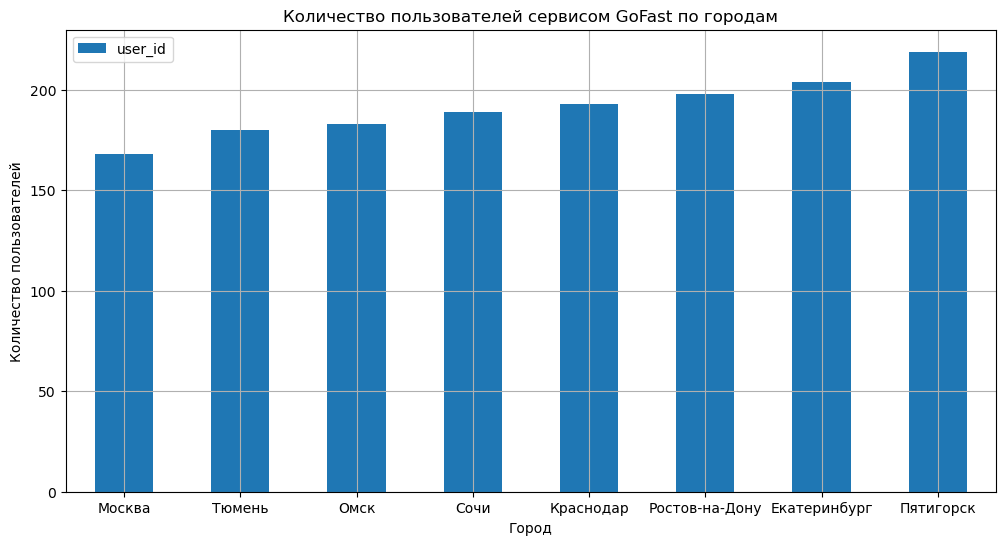

In [14]:
# построим столбчатую диаграмму с городами
users.groupby('city', as_index=False).count()\
.sort_values(by='user_id').plot(x='city', y='user_id', kind='bar', figsize=(12, 6),grid=True, xlabel='Город', rot=0,\
                               ylabel='Количество пользователей', title='Количество пользователей сервисом GoFast по городам');

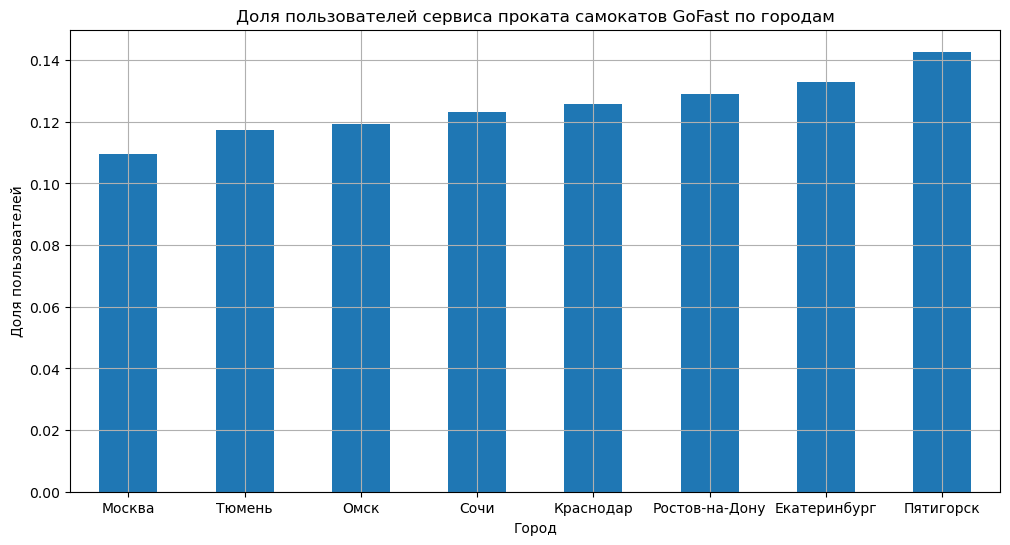

In [15]:
# узнаем размер датафрейма users - 1 значение - будет общее число пользователей во всех городах
shape_users = users.shape

# доля пользователей нашиx пользователей сервисом по городам
user_shares_by_city = users.groupby('city')['user_id'].count() / shape_users[0]

#визуализирем в виде столчатой диаграммы
user_shares_by_city.sort_values().plot(x=user_shares_by_city.index, y='user_id', kind='bar', grid=True, xlabel='Город',\
                                      ylabel='Доля пользователей', figsize=(12, 6),\
                                       title='Доля пользователей сервиса проката самокатов GoFast по городам', rot=0);

Все города представлены примерно одинаково в нашей выборке. Наибольшее количество пользователей нашим сервисом проката самокатов в Пятигорске - 219, а наименьшее, как ни странно, в Москве - 168. По долям: все доли находятся в предлах от 11 процентов до 14 с небольшим процента. Разброс впринципе не очень большой - при идеальном равенстве у всех городов было бы по 12.5%.

### Исследуем количество пользователей с подпиской и без неё.

In [16]:
# считаем пользователей с подпиской
users_with_subscription = users.query('subscription_type == "ultra"').subscription_type.count()
print(users_with_subscription)

# и без неё
users_without_subscription = users.query('subscription_type == "free"').subscription_type.count()
print(users_without_subscription)

699
835


Доля пользователей с подпиской ultra - 45.57%
Доля пользователей без подписки - 54.43%


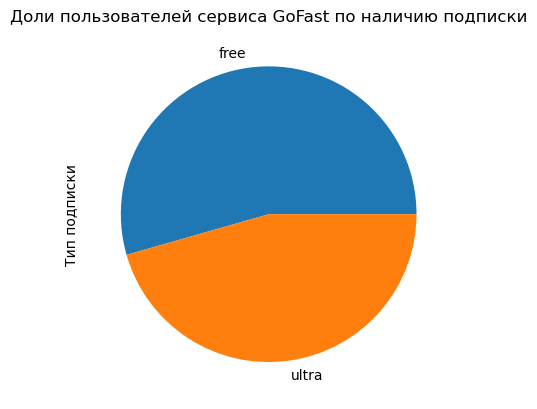

In [17]:
# считаем доли и визуализируем их
users.groupby('subscription_type')\
.subscription_type.count().plot(kind='pie',title='Доли пользователей сервиса GoFast по наличию подписки',\
                                ylabel='Тип подписки');
print(f'Доля пользователей с подпиской ultra - {users_with_subscription / (users_with_subscription + users_without_subscription):.2%}')
print(f'Доля пользователей без подписки - {users_without_subscription / (users_with_subscription + users_without_subscription):.2%}')

Как видно из анализа - доля пользователей без подписки немного выше, чем у тех у кого подписка есть. Группы достаточно многочисленны. Логично будет предположить, что и их поведение будет различно. Но это проверим несколько позже.

### Исследуем возраст пользователей

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
5%         17.000000
25%        22.000000
50%        25.000000
75%        28.000000
80%        29.000000
95%        33.000000
max        43.000000
Name: age, dtype: float64

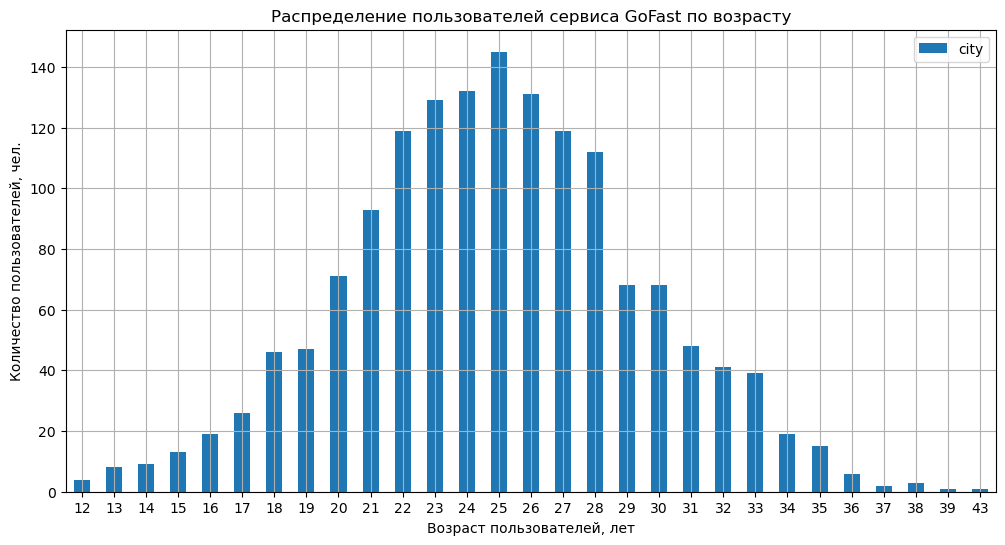

In [18]:
# выводим статистику о возрасте и строим столбчатый график
users.groupby('age', as_index=False).count().plot(x='age', y='city', kind='bar', figsize=(12, 6), grid=True,\
                                                  ylabel='Количество пользователей, чел.', xlabel='Возраст пользователей, лет',\
                                                  title='Распределение пользователей сервиса GoFast по возрасту', rot=0);
users.age.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.8, 0.95])

Итак: у нас есть пользователи от 12 до 43 лет. Пользователи возрастом старше у этому явно люди не привыкшие. Притом значение 43 года и так уже напоминает выброс и не входит в разброс + 3 стандартных отклонения. 25 лет - средний возраст. Распределение нормальное.

### Исследуем расстояние, которое пользователь преодолел за 1 поездку

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
5%         689.007279
25%       2543.226360
50%       3133.609994
75%       3776.222735
80%       3975.359574
95%       4740.088596
max       7211.007745
Name: distance, dtype: float64

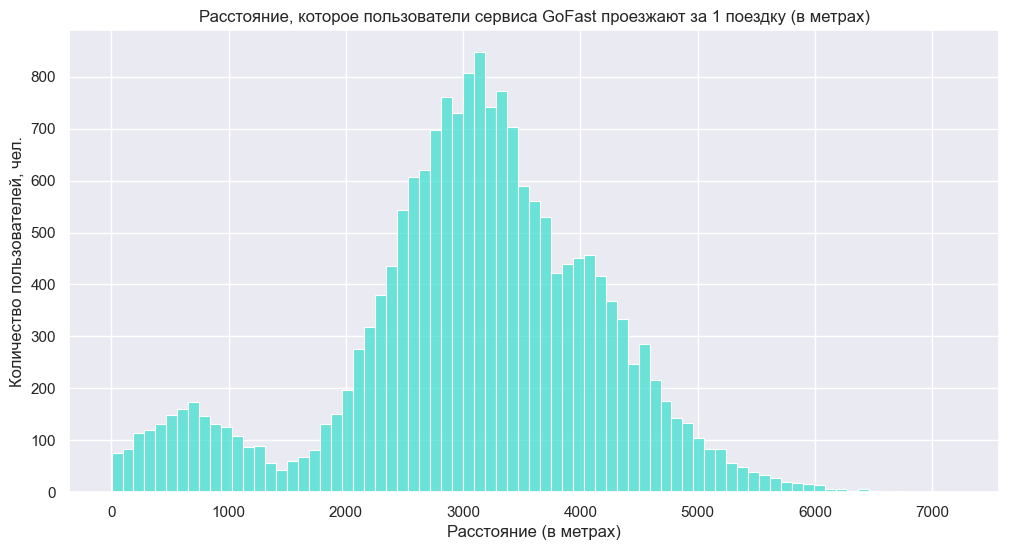

In [19]:
# выводим статистику и строим гистограмму частот о расстоянии за 1 поездку
sns.set(rc={'figure.figsize':(12, 6)})
ax = sns.histplot(rides.distance, color='turquoise')
ax.set(xlabel='Расстояние (в метрах)', ylabel='Количество пользователей, чел.', \
       title='Расстояние, которое пользователи сервиса GoFast проезжают за 1 поездку (в метрах)');
rides.distance.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.8, 0.95])

Все поездки у нас от случайных (до 1 метра) и до 7211 метров. При этом среднее расстояние, которое проезжают за 1 поездку - 3070 метров, медианное значение немного больше - 3133 метра. Стандартное отклонение - 1116 метров. То есть большинство поездок идут от 1954 до 4186 метров. Отдельно отметим 5% самых маленьких поездок - не дальше 689 метров, а 5% самых длинных поездок - от 4740 до 7211 метров. Часть значений не попадёт в +3 стандартных отклонения от среднего - это поездки длиннее 6418 метров. Их не много - предполагаю не более 1%. Но при этом это не выбросы. 

### Исследуем продолжительность поездок

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
5%           8.244528
25%         13.597563
50%         17.678395
75%         21.724800
80%         22.780542
95%         28.428730
max         40.823963
Name: duration, dtype: float64

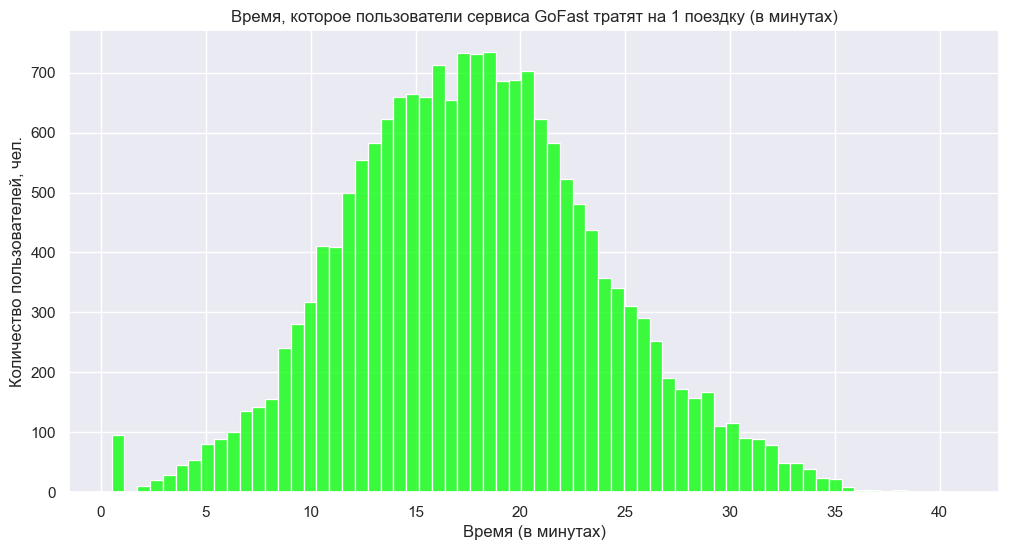

In [20]:
# выводим статистику о продолжительности поездок и строим гистограмму частот
ax = sns.histplot(rides.duration, color='lime')
ax.set(xlabel='Время (в минутах)', ylabel='Количество пользователей, чел.', \
       title='Время, которое пользователи сервиса GoFast тратят на 1 поездку (в минутах)');
rides.duration.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.8, 0.95])

Продолжительность поездок - от 30 секунд до 40 минут. Средняя продолжительность поездки - немногим больше 17.5 минут. Среднее и медиана почти сопадают. Стандартное отклонение - немногим больше 6 минут. Распределение абсолютно нормальное, за исключением некоторого всплеска коротких поездок примерно до 2 минут. Как и в прошлый раз будут значения, которые не попадают в +3 стандартных отклонения от среднего - это поездки длиннее 36 минут. Их снова немного - опять в пределах 1%, что соответствует исследованию расстояния. 5% самых коротких поездок длятся не больше 8 минут 15 секунд, а 5% самых длинных поездок - от 28 до 40 минут. Средняя скорость езды на электросамокате - немногим больше 10 км/час (172 метра в минуту).


##  Объединение данных

### Объединяем датафреймы о пользователях, поездках и подписках в один большой

In [21]:
# создаём новый большой датафрейм
all_data = rides.merge(users, on='user_id', how='inner')
all_data = all_data.merge(subscriptions, on='subscription_type', how='inner')

# выводим для проверки новую таблицу со всеми данными
all_data.head(10)

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
5,1,2770.890808,16.650138,2021-10-09,10,Кира,22,Тюмень,ultra,6,0,199
6,1,3039.020292,14.927879,2021-10-19,10,Кира,22,Тюмень,ultra,6,0,199
7,1,2842.118050,23.117468,2021-11-06,11,Кира,22,Тюмень,ultra,6,0,199
8,1,3412.690668,15.238072,2021-11-14,11,Кира,22,Тюмень,ultra,6,0,199
9,1,748.690645,15.041884,2021-11-22,11,Кира,22,Тюмень,ultra,6,0,199


### Создаём два новых датафрейма с пользователями с подписками и без подписок

In [22]:
# создаём датафрейм о пользователях с подпиской
data_users_with_subscription = all_data.query("subscription_type == 'ultra'")

# создаём датфрейм о пользователях без подписки
data_users_without_subscription = all_data.query("subscription_type == 'free'")

# смотрим на открытие новых датафреймов
display(data_users_with_subscription.tail(10))
data_users_without_subscription.tail(10)

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6490,698,3240.512798,17.837762,2021-09-03,9,Егор,26,Пятигорск,ultra,6,0,199
6491,698,2746.103421,13.297888,2021-10-20,10,Егор,26,Пятигорск,ultra,6,0,199
6492,699,3433.522627,19.734091,2021-03-29,3,Оксана,22,Москва,ultra,6,0,199
6493,699,4072.797406,16.575991,2021-06-02,6,Оксана,22,Москва,ultra,6,0,199
6494,699,3045.277646,19.610605,2021-08-25,8,Оксана,22,Москва,ultra,6,0,199
6495,699,3973.046497,24.671163,2021-08-29,8,Оксана,22,Москва,ultra,6,0,199
6496,699,3288.702563,15.892886,2021-09-12,9,Оксана,22,Москва,ultra,6,0,199
6497,699,3076.159348,14.389525,2021-09-26,9,Оксана,22,Москва,ultra,6,0,199
6498,699,4707.845501,15.839579,2021-10-17,10,Оксана,22,Москва,ultra,6,0,199
6499,699,3202.890770,25.217345,2021-12-03,12,Оксана,22,Москва,ultra,6,0,199


,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
18058,1534,195.447469,6.469074,2021-06-11,6,Альберт,25,Краснодар,free,8,50,0
18059,1534,3214.021065,18.343604,2021-06-18,6,Альберт,25,Краснодар,free,8,50,0
18060,1534,3644.708038,20.289416,2021-08-08,8,Альберт,25,Краснодар,free,8,50,0
18061,1534,3977.744996,26.916544,2021-08-20,8,Альберт,25,Краснодар,free,8,50,0
18062,1534,4928.173852,22.560373,2021-09-13,9,Альберт,25,Краснодар,free,8,50,0
18063,1534,3781.098080,19.822962,2021-11-04,11,Альберт,25,Краснодар,free,8,50,0
18064,1534,2840.423057,21.409799,2021-11-16,11,Альберт,25,Краснодар,free,8,50,0
18065,1534,3826.185507,18.435051,2021-11-18,11,Альберт,25,Краснодар,free,8,50,0
18066,1534,2902.308661,16.674362,2021-11-27,11,Альберт,25,Краснодар,free,8,50,0
18067,1534,2371.711192,15.893917,2021-12-29,12,Альберт,25,Краснодар,free,8,50,0


### Визуализируем данные о расстоянии и времени поездок по категориям

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
5%       1119.722350
25%      2785.444017
50%      3148.637229
75%      3560.574425
80%      3719.778987
95%      4382.285625
max      5699.769662
Name: distance, dtype: float64

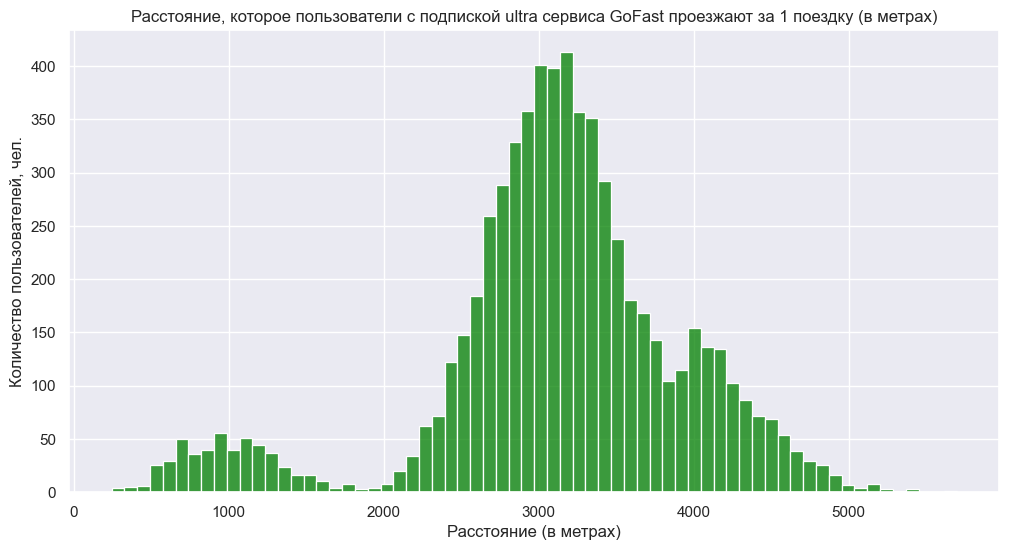

In [23]:
# исследуем расстояние, которые проезжают за поездку пользователи с подпиской
ax = sns.histplot(data_users_with_subscription.distance, color='green')
ax.set(xlabel='Расстояние (в метрах)', ylabel='Количество пользователей, чел.', \
       title='Расстояние, которое пользователи с подпиской ultra сервиса GoFast проезжают за 1 поездку (в метрах)');
data_users_with_subscription.distance.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.8, 0.95])

График расстояния поездки в категории с подписками совпадает по форме с расстоянием, которое преодолели все пользователи. Среднее расстояние и медиана немного больше, чем в общем (3115 метров против 3070 метров в среднем за поездку, 3148 метров против 3133 метров по медиане расстояния). Больше минимальное пройденное расстояние 244 метра против расстояния до метра среди всех пользователей и меньше максимальное расстояние - 5699 метров против 7211 среди всех пользователей. Конечно, из-за этого меньше стандартное отклонение в этой категории, чем в среднем по всей выборке (836 метров против 1116 метров среди всех пользователей). В целом люди в этой категории ездят немного больше и в целом стабильнее по расстоянию за 1 поездку - нет ни особо сверхмалых расстояний, но и сверхбольших тоже мало.

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
5%         524.185294
25%       2366.562689
50%       3114.648465
75%       3905.697894
80%       4086.734287
95%       4934.728012
max       7211.007745
Name: distance, dtype: float64

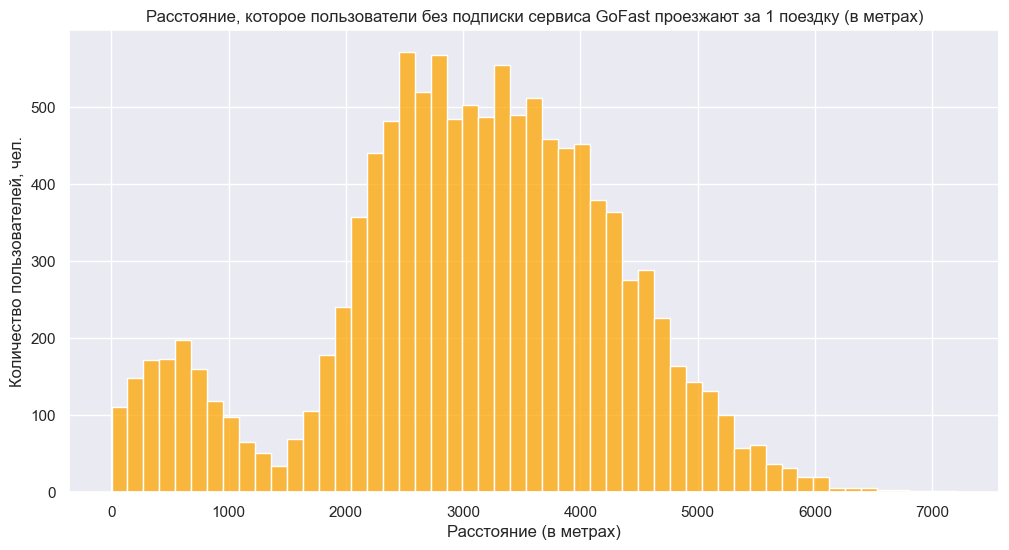

In [24]:
# исследуем расстояние, которые проезжают за поездку пользователи без подписки
ax = sns.histplot(data_users_without_subscription.distance, color='orange')
ax.set(xlabel='Расстояние (в метрах)', ylabel='Количество пользователей, чел.', \
       title='Расстояние, которое пользователи без подписки сервиса GoFast проезжают за 1 поездку (в метрах)');
data_users_without_subscription.distance.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.8, 0.95])

Выводы сторого противоположны категории людей с подпиской. Меньше среднее и медианное расстояние одной поездки и по сравнению и со средним между всех пользователей и тем более людей с подпиской (3045 метров среднее в категории людей без подписки меньше 3070 метров в среднем от всех и 3115 метров в категории людей с подписками). Тоже самое с медианой (3114 метров в этой категории меньше 3133 метров среди всех пользователей и меньше 3148 метров в категории людей с подписками). Но выше стандартное отклонение - 1248 метров в группе без подписки против 1116 в среднем по всем группам и 836 метров в группе с подпиской. Из-за этого и 3 квартиль выше, и 80% выше, и 95% выше и максимальное значение тоже выше.

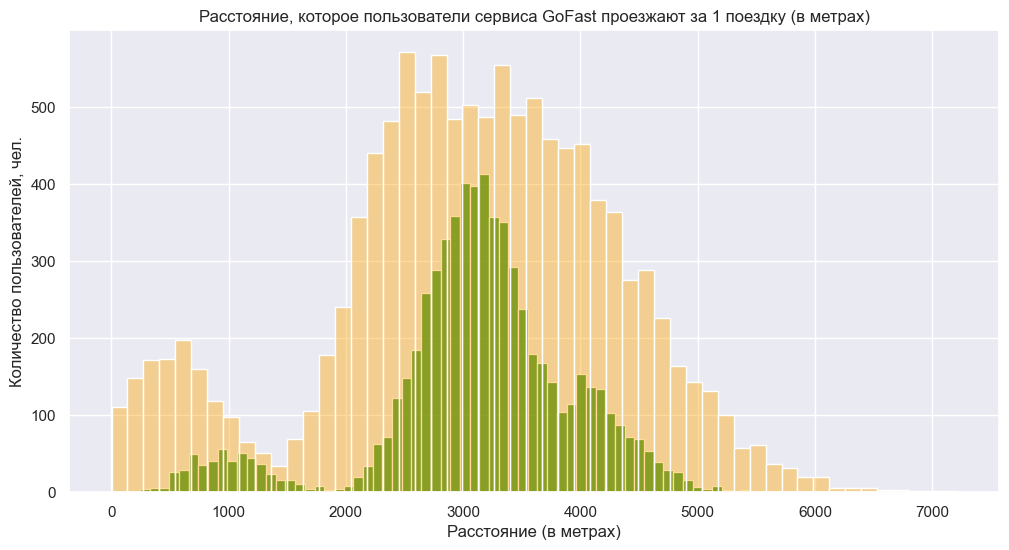

In [25]:
# наложим друг на друга 2 графика с расстоянием длины поездки
ax = sns.histplot(data_users_with_subscription.distance, color='green')
sns.histplot(data_users_without_subscription.distance, color='orange', ax=ax, alpha=0.4)
ax.set(xlabel='Расстояние (в метрах)', ylabel='Количество пользователей, чел.', \
       title='Расстояние, которое пользователи сервиса GoFast проезжают за 1 поездку (в метрах)');

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
5%         10.264039
25%        14.524654
50%        18.178153
75%        21.884129
80%        23.014407
95%        28.720878
max        40.823963
Name: duration, dtype: float64

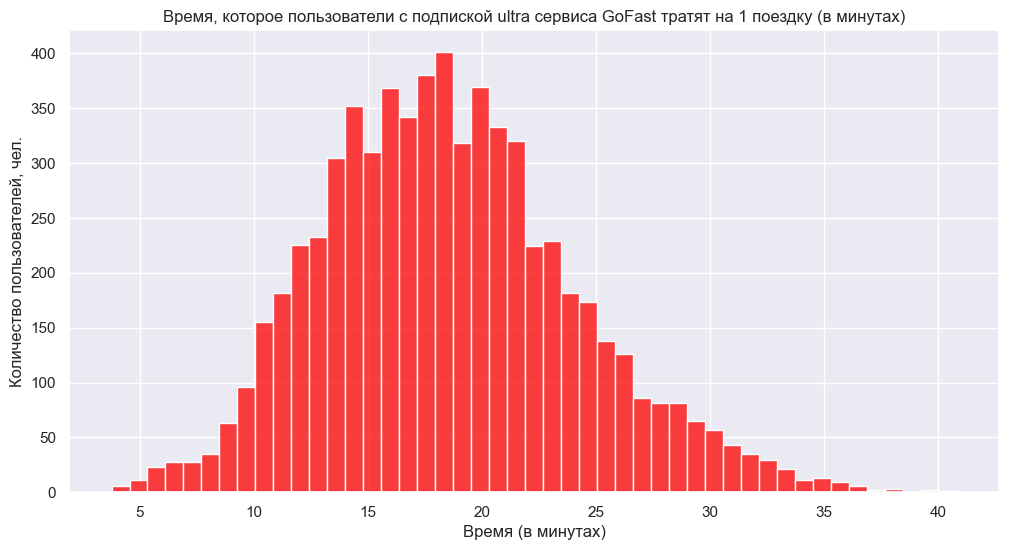

In [26]:
# исследуем время поездки среди группы пользователей с подписками
ax = sns.histplot(data_users_with_subscription.duration, color = 'red')
ax.set(xlabel='Время (в минутах)', ylabel='Количество пользователей, чел.', \
       title='Время, которое пользователи с подпиской ultra сервиса GoFast тратят на 1 поездку (в минутах)');
data_users_with_subscription.duration.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.8, 0.95])

Логично, если предположить что если в группе с подписками больше расстояние в одной поездке - то выше будет и среднее время, чем в среднем по всем категориям. Это мы и наблюдаем - здесь среднее время 18.5 минуты и медиана 18.2 минуты это выше, чем в среднем 17.8 и 17.68 по медианному времени поездки среди всех пользователей. Здесь же и рекорд по длительности поездки - 40.82 минуты. И минимальное время в этой группе 3.76 минуты - против 0.5 минуты среди всех. Из-за этого ниже стандартное отклонение в этой группе - 5.57 минуты против 6.09 минут среди всех пользователей.

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
5%           7.244460
25%         12.958437
50%         17.326890
75%         21.594071
80%         22.648008
95%         28.246500
max         34.948498
Name: duration, dtype: float64

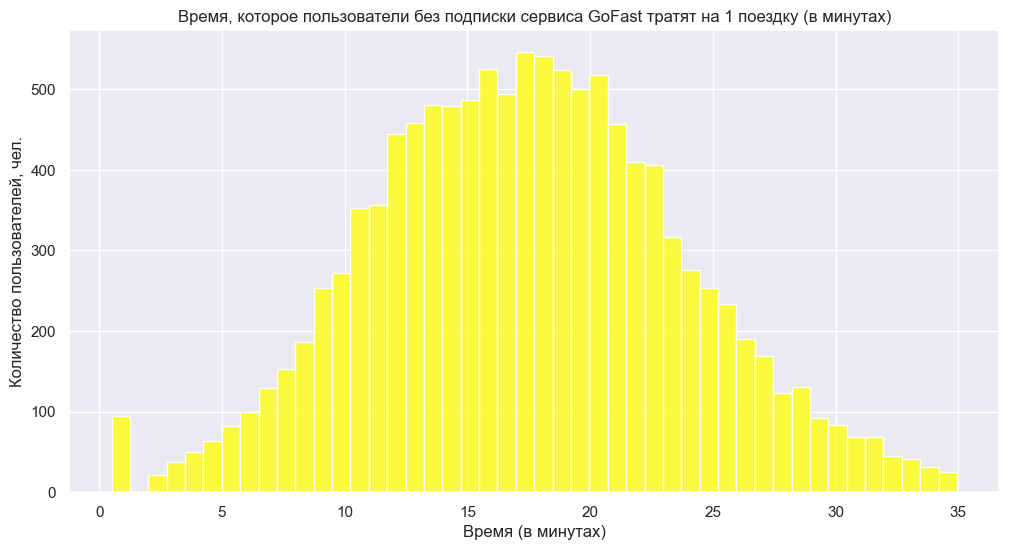

In [27]:
# исследуем время среди группы без подписок
ax = sns.histplot(data_users_without_subscription.duration, color = 'yellow')
ax.set(xlabel='Время (в минутах)', ylabel='Количество пользователей, чел.', \
       title='Время, которое пользователи без подписки сервиса GoFast тратят на 1 поездку (в минутах)');
data_users_without_subscription.duration.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.8, 0.95])

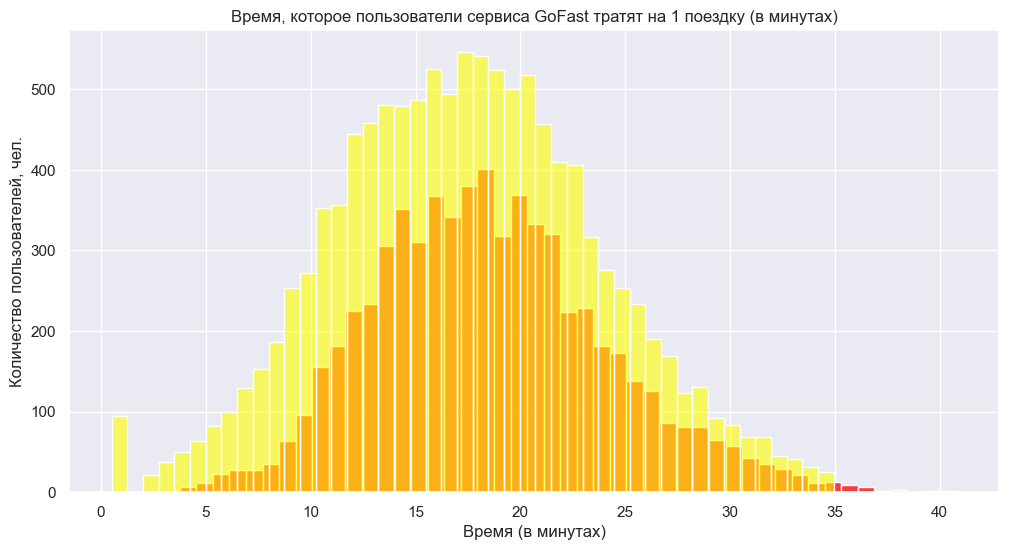

In [28]:
#совместим графики по времени
ax = sns.histplot(data_users_with_subscription.duration, color = 'red')
sns.histplot(data_users_without_subscription.duration, color = 'yellow', ax=ax, alpha=0.6)
ax.set(xlabel='Время (в минутах)', ylabel='Количество пользователей, чел.', \
       title='Время, которое пользователи сервиса GoFast тратят на 1 поездку (в минутах)');

Вот и ожидаемые отличия - среднее и медианное время поездки ниже группы пользователей с подписками. 17.39 минуты в этой группе против 18.54 минуты в группе с подписками; медиана 17.32 минуты в этой группе против 18.18 минут в группе пользователей с подписками. Максимальное время поездки в этой группе 34.95 минут в этой группе против 40.82 минуты в группе с подписками и минимальное время 0.5 минуты и относительно большой всплеск до 2 минут времени примерно 100 значений (минимальное время в группе с подписками - 3.76 минуты). Стандартное отклонение времени в этой группе выше, чем в группе с подписками - 6.32 минуты против 5.57 минуты. Скорее всего это из-за этого всплеска.

##  Подсчёт выручки

### Создаём датафрейм с агрегированными данными о поездках

In [29]:
# создаём новый столбец для анализа данных - время использованное пользователем в пути,округлённое в большую сторону из-за поминутной тарификации
def time_up(duration):
    return math.ceil(duration)

all_data['ceil_duration'] = all_data.duration.apply(time_up)

# создаём новый датафрейм с агрегированными данными
aggregated_data = all_data.groupby(['user_id', 'month'], as_index=False).aggregate({'distance': 'sum', 'ceil_duration': 'sum', 'name': 'count'})

# переименуем столбцы для лучшего понимания, что чем является
aggregated_data.columns = ['user_id', 'month', 'sum_distance', 'sum_duration', 'trips_per_month']
# смотрим на результат агрегации
aggregated_data.head(10)

,user_id,month,sum_distance,sum_duration,trips_per_month
0,1,1,7027.511294,42,2
1,1,4,754.159807,7,1
2,1,8,6723.470560,46,2
3,1,10,5809.911100,32,2
4,1,11,7003.499363,56,3
5,1,12,6751.629942,28,2
6,2,3,10187.723006,63,3
7,2,4,6164.381824,40,2
8,2,6,3255.338202,14,1
9,2,7,6780.722964,48,2


### Производим подсчёт выручки

In [30]:
# объединим снова таблицы - не хватает данных о стоимости поездки и подписки для пользователей
aggregated_data = aggregated_data.merge(users, on='user_id', how='inner')
aggregated_data = aggregated_data.merge(subscriptions, on='subscription_type', how='inner')

# смотрим на предварительный результат
aggregated_data.head(10)

,user_id,month,sum_distance,sum_duration,trips_per_month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,7027.511294,42,2,Кира,22,Тюмень,ultra,6,0,199
1,1,4,754.159807,7,1,Кира,22,Тюмень,ultra,6,0,199
2,1,8,6723.470560,46,2,Кира,22,Тюмень,ultra,6,0,199
3,1,10,5809.911100,32,2,Кира,22,Тюмень,ultra,6,0,199
4,1,11,7003.499363,56,3,Кира,22,Тюмень,ultra,6,0,199
5,1,12,6751.629942,28,2,Кира,22,Тюмень,ultra,6,0,199
6,2,3,10187.723006,63,3,Станислав,31,Омск,ultra,6,0,199
7,2,4,6164.381824,40,2,Станислав,31,Омск,ultra,6,0,199
8,2,6,3255.338202,14,1,Станислав,31,Омск,ultra,6,0,199
9,2,7,6780.722964,48,2,Станислав,31,Омск,ultra,6,0,199


In [31]:
# создаём столбец с сумарной выручкой - для её подсчёта надо взять продолжительность поездки (уже округлено в большую сторону)
# потом умножить результат на количество минут и прибавить к этому стоимость подписки
def sum_revenue (row):
    return row.sum_duration * row.minute_price + row.subscription_fee

aggregated_data['sum_revenue'] = aggregated_data.apply(sum_revenue, axis=1)

# проверям успешность создания столбца
aggregated_data.head(10)

,user_id,month,sum_distance,sum_duration,trips_per_month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,sum_revenue
0,1,1,7027.511294,42,2,Кира,22,Тюмень,ultra,6,0,199,451
1,1,4,754.159807,7,1,Кира,22,Тюмень,ultra,6,0,199,241
2,1,8,6723.470560,46,2,Кира,22,Тюмень,ultra,6,0,199,475
3,1,10,5809.911100,32,2,Кира,22,Тюмень,ultra,6,0,199,391
4,1,11,7003.499363,56,3,Кира,22,Тюмень,ultra,6,0,199,535
5,1,12,6751.629942,28,2,Кира,22,Тюмень,ultra,6,0,199,367
6,2,3,10187.723006,63,3,Станислав,31,Омск,ultra,6,0,199,577
7,2,4,6164.381824,40,2,Станислав,31,Омск,ultra,6,0,199,439
8,2,6,3255.338202,14,1,Станислав,31,Омск,ultra,6,0,199,283
9,2,7,6780.722964,48,2,Станислав,31,Омск,ultra,6,0,199,487


count    4533.000000
mean      362.792191
std        88.262737
min       223.000000
5%        271.000000
25%       301.000000
50%       337.000000
75%       409.000000
80%       427.000000
95%       541.000000
max       955.000000
Name: sum_revenue, dtype: float64

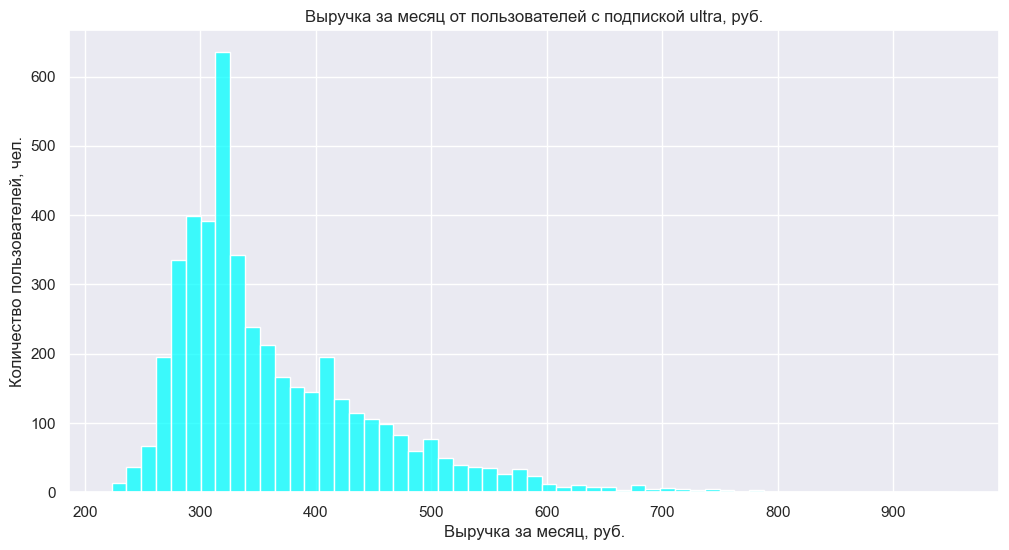

In [32]:
# исследуем выручку за месяц у пользователей с подпиской
ax = sns.histplot(aggregated_data.query("subscription_type == 'ultra'").sum_revenue, color='cyan')
ax.set(title='Выручка за месяц от пользователей с подпиской ultra, руб.', xlabel='Выручка за месяц, руб.',\
       ylabel='Количество пользователей, чел.');
aggregated_data.query("subscription_type == 'ultra'").sum_revenue.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.8, 0.95])

count    6798.000000
mean      243.557517
std       143.010897
min         8.000000
5%         80.000000
25%       144.000000
50%       208.000000
75%       320.000000
80%       352.000000
95%       520.000000
max      1144.000000
Name: sum_revenue, dtype: float64

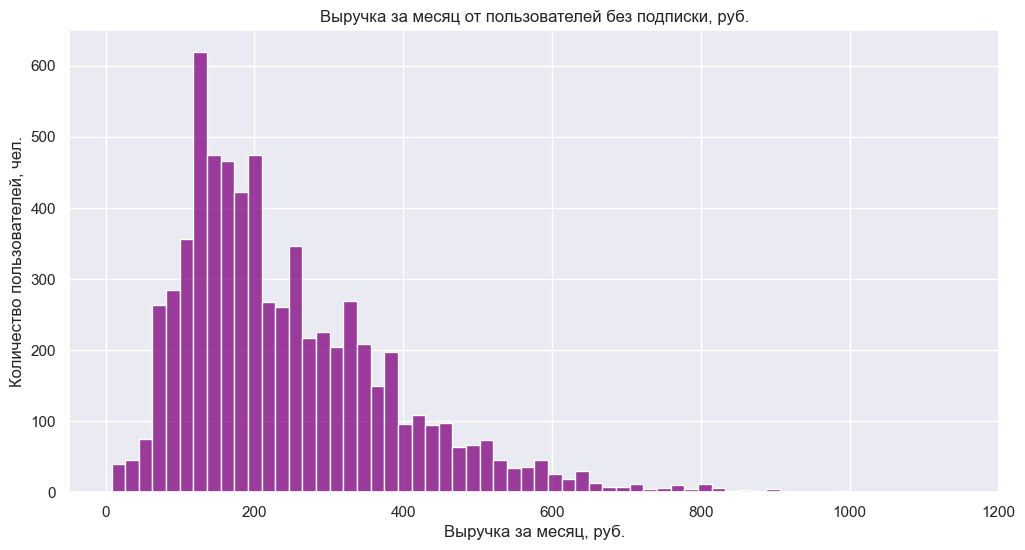

In [33]:
# исследуем выручку за месяц у пользователей без подписки
ax = sns.histplot(aggregated_data.query("subscription_type == 'free'").sum_revenue, color='purple')
ax.set(title='Выручка за месяц от пользователей без подписки, руб.', xlabel='Выручка за месяц, руб.',\
       ylabel='Количество пользователей, чел.');
aggregated_data.query("subscription_type == 'free'").sum_revenue.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.8, 0.95])

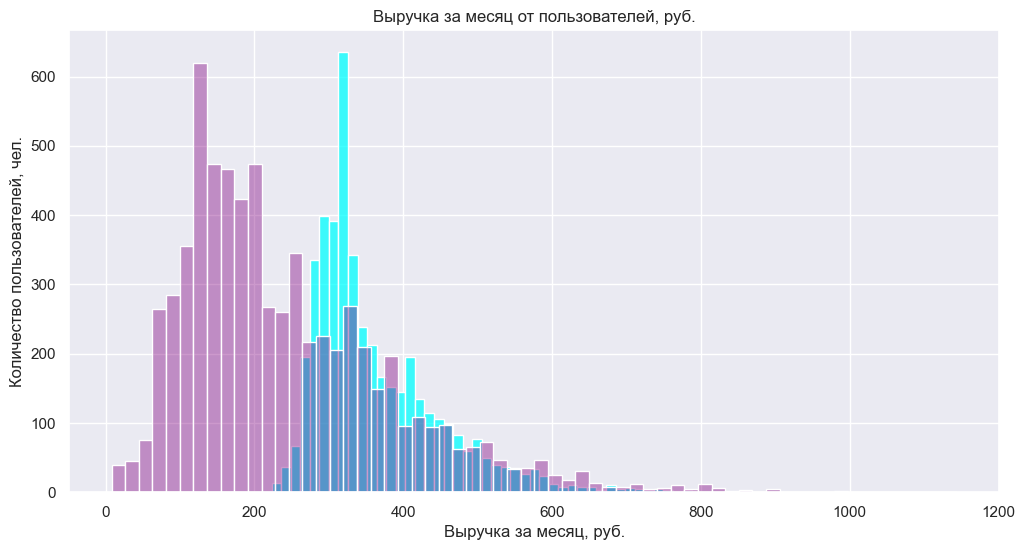

In [34]:
# совмещаем графики для большей наглядности
ax = sns.histplot(aggregated_data.query("subscription_type == 'ultra'").sum_revenue, color='cyan')
sns.histplot(aggregated_data.query("subscription_type == 'free'").sum_revenue, color='purple', ax=ax, alpha=0.4)
ax.set(title='Выручка за месяц от пользователей, руб.', xlabel='Выручка за месяц, руб.',\
       ylabel='Количество пользователей, чел.');

Пользователи с подпиской приносят больше заработков сервису в среднем - 362 рубля против 243 рублей у пользователей без подписки. Тоже самое с медианой - 337 рублей против 208 рублей у пользователей без подписки. Единственное, в чём пользователи без подписки превзошли пользователей с подпиской - это в максимальной сумме - 1144 рубля против 955 рублей. И соответственно из-за этого у пользователей без подписки выше стандартное отклонение - почти 143 рубля против 88 рублей. Отсюда проситься вывод: сервис заинтересован в пользователях с подпиской и при этом достаточно сильно.

## Проверка гипотез

### Проверяем гипотезу о разности времени на поездку среди пользователей с подпиской и без неё

Нулевая гипотеза (H0) - Средняя продолжительность поездки пользователей с подпиской почти не отличается от пользователей без подписки.
Альтернативная гипотеза (H1) - Средняя продолжительность поездки значительно больше у пользователей с подпиской, чем без неё.
Проверим гипотезу с уровнем статистической значимости в 1%.

In [35]:
# проверка гипотезы - у пользователей с подпиской время на поездку больше
alpha = 0.01 # уровень статистической значимости этой гипотезы

results = st.ttest_ind(data_users_with_subscription.duration, data_users_without_subscription.duration, alternative='greater')
print('p-значение', results.pvalue)
print('Отвергаем гипотезу о равенстве среднего времени поездки' if results.pvalue < alpha \
      else 'Не удалось отвергнуть гипотезу о равенстве среднего времени 1 поездки')
print(f'Среднее время поездки в группе с подпиской ultra {data_users_with_subscription.duration.mean():.2f} минут')
print(f'Среднее время поездки в группе без подписки {data_users_without_subscription.duration.mean():.2f} минут')

p-значение 1.2804098316645618e-34
Отвергаем гипотезу о равенстве среднего времени поездки
Среднее время поездки в группе с подпиской ultra 18.54 минут
Среднее время поездки в группе без подписки 17.39 минут


Гипотеза о равенстве среднего времени поездки целиком и полностью опровергнута. Значения несовпадают вообще никак. Попадают именно туда, где значения выше. Что полностью совпадает с гистограммами выше. Напомним о том, что получили выше - средняя продолжительность поездки у группы с подпиской - 18.54 минуты, и стандартное отклонение у неё - 5.57 минуты. А у группы без подписки - 17.39 минуты и стандартное отклонение - 6.32 минуты. Конечно, первая группа ездит дольше, а значит и денег приносит нам в итоге.

### Проверяем гипотезу о поездках на расстояние не большее, чем 3130 метров за поезку среди пользователей с подпиской

Нулевая гипотеза (H0) - Средняя поездка пользователей с подпиской больше или равна 3130 метрам.
Альтернативная гипотеза (H1) - Средняя поездка пользователей с подпиской меньше, чем 3130 метров.
Проверим гипотезу с уровнем статистической значимости в 5%.

In [36]:
# проверяем гипотезу о поездках на дистанцию не больше 3130 метров среди пользователей с подпиской
alpha = 0.05
optimal_distance = 3130 # пробег больше такого расстояния за поездку не очень желателен (в метрах)

results = st.ttest_1samp(data_users_with_subscription.distance, optimal_distance, alternative='less')
print('p-значение', results.pvalue)
print('Опровергаем гипотезу о том, что поездки пользователей с подпиской больше или равны 3130 метрам' if results.pvalue < alpha \
     else 'Не удалось опровергнуть гипотезу о том, что поездки пользователей с подпиской больше или равны 3130 метрам')
print(f'Средняя поездка в группе с подпиской ultra - {data_users_with_subscription.distance.mean():.2f} метров')

p-значение 0.08046311521502146
Не удалось опровергнуть гипотезу о том, что поездки пользователей с подпиской больше или равны 3130 метрам
Средняя поездка в группе с подпиской ultra - 3115.45 метров


Итак, напомним статистктику о группе средней длине поездки пользователей с подпиской - среднее длина поездки 3115 метров, стандартное отклонение - 836 метров, медиана - 3148 метров. Оказывается этого отклонения не досточно, чтобы считать, что длина поездки значимо меньше, чем 3130 метров.
Можно дополнительно проверить гипотезу о равенстве длины поездок с оптимальной длиной проката. Если она оправдается - это тоже результат.

Нулевая гипотеза (H0) - Средняя поездка пользователей с подпиской примерно равна 3130 метрам.
Альтернативная гипотеза (H1) - Средняя поездка пользователей с подпиской не равна 3130 метрам.
Проверим гипотезу с уровнем статистической значимости в 5%.

In [37]:
# не является ли наша длина поездки оптимальной?
aplha = 0.05

results = st.ttest_1samp(data_users_with_subscription.distance, optimal_distance)
print('p-значение', results.pvalue)
print('Отвергаем гипотезу о том, что длина поездки примерно не равна оптимальной' if results.pvalue < alpha \
      else 'Не удалось отвергнуть гипотезу, что длина поездки примерно не равна оптимальной')
print(f'Средняя поездка в группе с подпиской ultra {data_users_with_subscription.distance.mean():.2f} метров')

p-значение 0.16092623043004292
Не удалось отвергнуть гипотезу, что длина поездки примерно не равна оптимальной
Средняя поездка в группе с подпиской ultra 3115.45 метров


Вообще говоря если смотреть по статистике об этом распределении это ожидаемый резльтат. Напомним ещё раз: среднее значение длины поездки в группе с подпиской - 3115 метров, медиана длины поездки в ней - 3148 метров, стандартное отклонение - 836 метров. Прочая статистика про длину поездок в этой группе: минимальное расстояние - 244 метра, максимальное расстояние - 5699 метров. И это может примерно соответствовать средней дистанции в 3130 метров, а вот доказать что это строго меньше - нам уже не удалось.

### Проверка гипотезы о том, что помесячная выручка от пользователей с подпиской выше, чем от пользователей без неё

Нулевая гипотеза (H0) - Средняя выручка группы пользователей с подписками равна выручке группы без подписок.
Альтернативная гипотеза (H1) - Средняя выручка группы с подписками значительно выше, чем в группе без подписок.
Проверим гипотезу с уровнем статистической значимости в 1%.

In [38]:
# проверка гипотезы - нам более выгоды пользователи с подпиской - они дают больше выручки
alpha = 0.01 # уровень значимости этой гипотезы

results = st.ttest_ind(aggregated_data.query("subscription_type == 'ultra'").sum_revenue,\
                       aggregated_data.query("subscription_type == 'free'").sum_revenue,\
                       equal_var=False, alternative='greater')
print('p-значение', results.pvalue)
print('Отвергаем гипотезу о равенстве выручки от пользователей с подпиской и без неё' if results.pvalue < alpha \
     else 'Не удалось отвергнуть гипотезу о равенстве выручки от пользователей с подпиской и без неё')
print('Средняя выручка в группе с подпиской ultra -', aggregated_data.query("subscription_type == 'ultra'").sum_revenue.mean().round(2), 'рубля.')
print('Средняя выручка в группе без подписки -', aggregated_data.query("subscription_type == 'free'").sum_revenue.mean().mean().round(2), 'рубля.')

p-значение 0.0
Отвергаем гипотезу о равенстве выручки от пользователей с подпиской и без неё
Средняя выручка в группе с подпиской ultra - 362.79 рубля.
Средняя выручка в группе без подписки - 243.56 рубля.


Голая статистика: средняя выручка в группе с подписками равна - 362 рубля, стандартное отклонение - 88 рублей. В группе без подписки - средняя выручка равна 243 рубля, а стандартное отклонение в группе без подписок - 143 рубля. И как результат:
Как мы уже и видели - такой возможности о том, что наши выручки есть одно и тоже просто не существует вообще. Нам однозначно нужны пользователи с подпиской - они гораздо больше приносят дохода.

### Проверим гипотезу о том, что после обновления серверов количество обращений в службу поддержки значительно снизилось

К сожалению, это лишь теоретическая задача. Но решается она так:
- считаем данные о раннем количестве обращений в службу поддержки и сохраним её в переменную выборка1
- считаем данные о более позднем количестве обращений в службу поддержки и сохраним её в переменную выборка2
- установим уровень значимости для этой задачи (чаще всего - 1% или 5%)
- использем метод `scipy.stats.ttest_rel(выборка1, выборка2, alternative='greater')` сохраняем в переменную результат
- сравниваем результат с уровнем значимости и если уровень значимости нашей задачи больше полученного, то гипотеза о том, что наше предположение верно - правдоподобно, в ином случае - признаём, что утверждать этого точно не можем.

## Распределения

### Произведём расчёт количества промокодов для рассылки пользователям, чтобы 100 существующих клиентов продлили подписку Ultra с вероятностью не выполнить этот план в 5%.

In [39]:
# сколько нужно промокодов?
p = 0.1 # вероятность продления подписки
target = 100 # не меньше чего хотим получить
n = 0 # количество требуемых отправок

for i in range(300, 2000):
    probability = st.binom.cdf(target, i, p)
    if probability <= 0.05:
        print(i)
        n = i
        break

1172


Итак нам нужны 1172 отправки, чтобы получить не меньше 100 клиентов, которые продлят её с вероятностью в 95%.

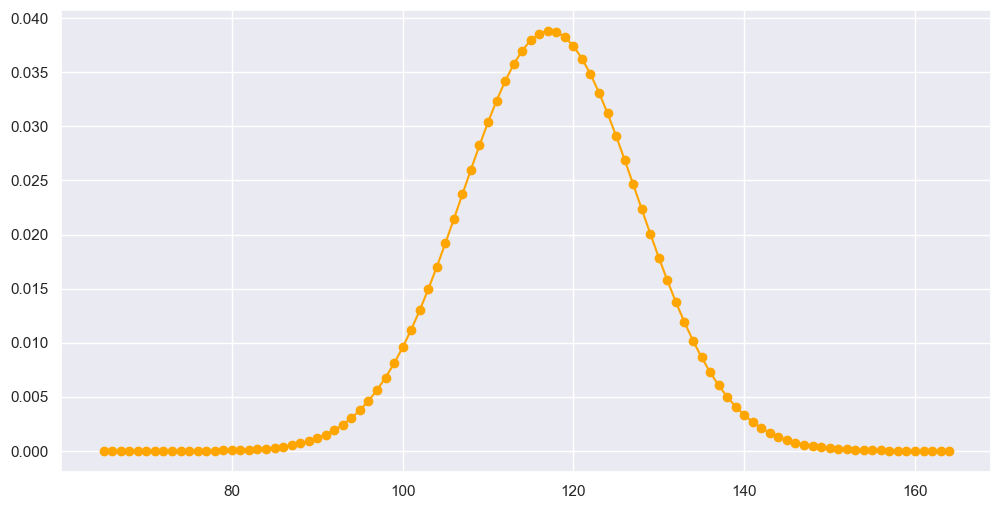

In [40]:
# апроксимируем к нормальному распределению
mu = n * p
std = (n * p * (1 - p))**0.5
distr = st.norm(mu, std)
# строим график
plt.rcParams['figure.figsize'] = (12, 6)
plt.plot(range(65, 165),distr.pdf(range(65,165)), color='orange', marker='o');

Нам нужны как минимум 1172 отправки промокодов, чтобы получить 100 клиентов, которые продлят эту подписку, с вероятностью неуспеха в 5%. При этом видно, что получить более 150 клиентов с подпиской почти невозможно при такой отправке - нужно больше отправок промокодов.

### Построим график распределения и оценим вероятность, того что после отсылки 11 млн push-уведомлений их откроют не более 399,5 тыс пользователей.

In [41]:
# праметры отправки push-уведомлений
p = 0.4 # вероятность открыть  push-уведомления
n_push = 11000 # тысяч отправленных push-уведомлений

# апроксимируем к нормальному распределению
mu_push = p * n_push
std_push = (p * n_push * (1 - p))**0.5

distr_push = st.norm(mu_push, std_push)
# выводим вероятность такого исхода
distr_push.cdf(399.5)

0.0

Это событие невероятно. Таких чудес не бывает. Ожидается в среднем 4400 тысяч открытых push-уведомлений.

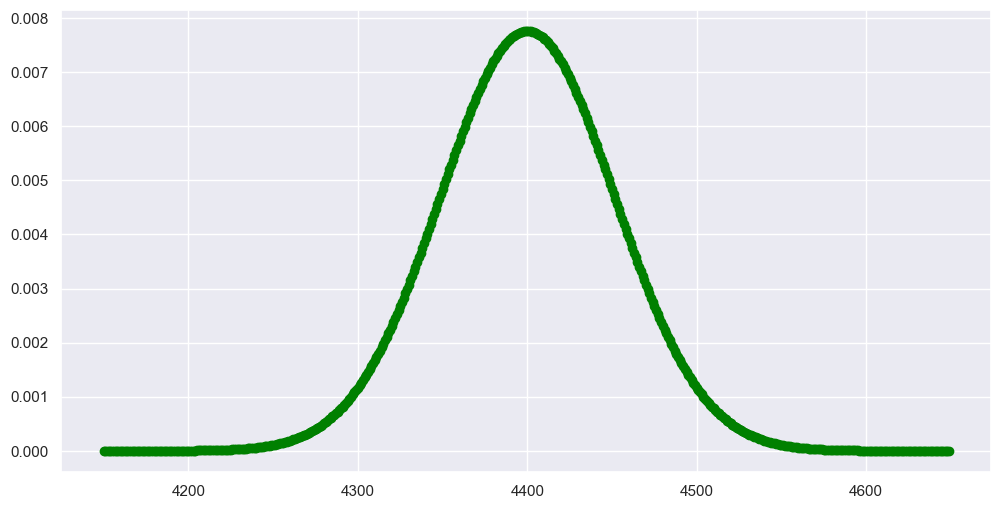

In [42]:
# строим график 
plt.plot(range(4150,4650),distr_push.pdf(range(4150,4650)), color='green', marker='o');

Мы можем получить примерно от 4200 тысяч открытых push - уведомлений до 4600 тысяч открытых push - уведомлений, а вот другие значения получить почти невозможно. И уж тем более невозможно получить столь мало как 399.5 тысяч открытых push - уведомлений.

## Общий вывод

У нашего сервиса немного больше пользователей без подписки - 54.43%, соответственно пользователей с подписой ultra - 45.57%. При этом количество поездок у пользователей без подписок значительно больше, чем у пользователей с подписками - и делятся они приблизительно 2 к 1. Наши клиенты - это люди в возрасте от 12 до 43 лет, при этом основную часть из них составляют молодые люди и девушки в возрасте от 22 до 28 лет. Наш сервис представлен в 8 городах и пользуются им примерно равномерно во всех этих городах. Наши пользователи проезжают от метра (хотя не очень понятно зачем) до 7211 метров. При этом люди с подписками в среднем ехдят на большее расстояние, но рекорд по расстояниям, которое проехал 1 пользователь за раз принадлежит пользователю без подписки. В среднем это расстояние ненамного больше 3 км. По времени 1 поездки - среднее время 17.8 минуты, но достигается она за счёт пользователей с подпиской - у них среднее время - 18.54 минуты, а вот у тех кого нет подписки среднее время больше, чем 1 минуту меньше - и оно составляет 17.32 минуты. Соответственно с выручкой тоже всё однозначно - из нашей выборки понятно, что намного большую выручку нам приносят пользователи с подпиской - в среднем 362 рубля против 243 рублей у группы без подписки. Но рекордную выручку нам всё-таки принёс пользователь без подписки - 1144 рубля за месяц. Все наши расхождения статистически значимы, кроме одного: мы не смогли опровергнуть, то что пользователи с подпиской в среднем ездят меньше оптимальной длины проезда в 3130 метров, но и это отнюдь не плохо для нас. Напоследок, мы выяснили, что для того, чтобы получить 100 новых пользователей с подписками нужно послать не меньше, чем 1172 промокода. И доказали, что при большом объёмме посылки push - уведолений (11 млн.), абсолютно невозможно, что наши уведомления посмотрят не очень много раз (400 тыс. или меньше)